In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Symbolics → SymbolicsForwardDiffExt
│  └─ Symbolics → SymbolicsPreallocationToolsExt
│ Precompilation will also be skipped for the following, which depend on the above cycle:
│   SSMC
│   MLSolver
└ @ Pkg.API.Precompilation ~/.julia/juliaup/julia-1.10.10+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/precompilation.jl:583
Precompiling packages...
  12192.9 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 15 seconds. 539 already precompiled. 4 skipped due to circular dependency.


In [3]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

In [4]:
import DataFrames: metadata as md

# Get a selection of systems for PDE runs

## Running the hss solver and linstab

In [354]:
@time df, cms = do_df_run2(10 .^ range(1, 2, 10), 20, 3;
    print_quality=false,
    m=base10_lognormal(0., 0.001), # to help distinguish species
    Ds=1e-6, # need higher as we will be running pdes on these
    # num_repeats=1,
);

cdf = make_counts_df(df)

extthreshold = 1e-6
df.numsurv = map(df.steadystates) do ss
    count(ss[1:md(df, "N")]) do ni
        ni > extthreshold
    end
end;

countmap(zip(df.sscode, df.lscode))

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:15┌ Warning: At t=840.4902815343563, dt was forced below floating point epsilon 1.1368683772161603e-13, and step error estimate = 0.00020560782440437307. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/MzuF2/src/integrator_interface.jl:673
┌ Error: maxresid reached is 1.4205e+24 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


 55.351799 seconds (118.74 M allocations: 20.086 GiB, 1.31% gc time)


Dict{Tuple{Int64, Union{Missing, Int64}}, Int64} with 4 entries:
  (1, 2)           => 25
  (1, 1)           => 20
  (2, 1)           => 154
  (-2000, missing) => 1

In [355]:
cdf

Row,K,num_runs,bad_ss,extinct,good_ss_bad_ls,nonext_stable,nonext_unstable
,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,10.0,20,0,19,0,0,1
2,12.9155,20,0,18,0,0,2
3,16.681,20,0,16,0,0,4
4,21.5443,20,0,16,0,0,4
5,27.8256,20,0,14,0,2,4
6,35.9381,20,0,15,0,0,5
7,46.4159,20,0,16,0,3,1
8,59.9484,20,1,10,0,6,3
9,77.4264,20,0,16,0,3,1


cm = Dict(0 => 154, 4 => 7, 5 => 3, 6 => 2, 2 => 12, 3 => 14, 1 => 8)


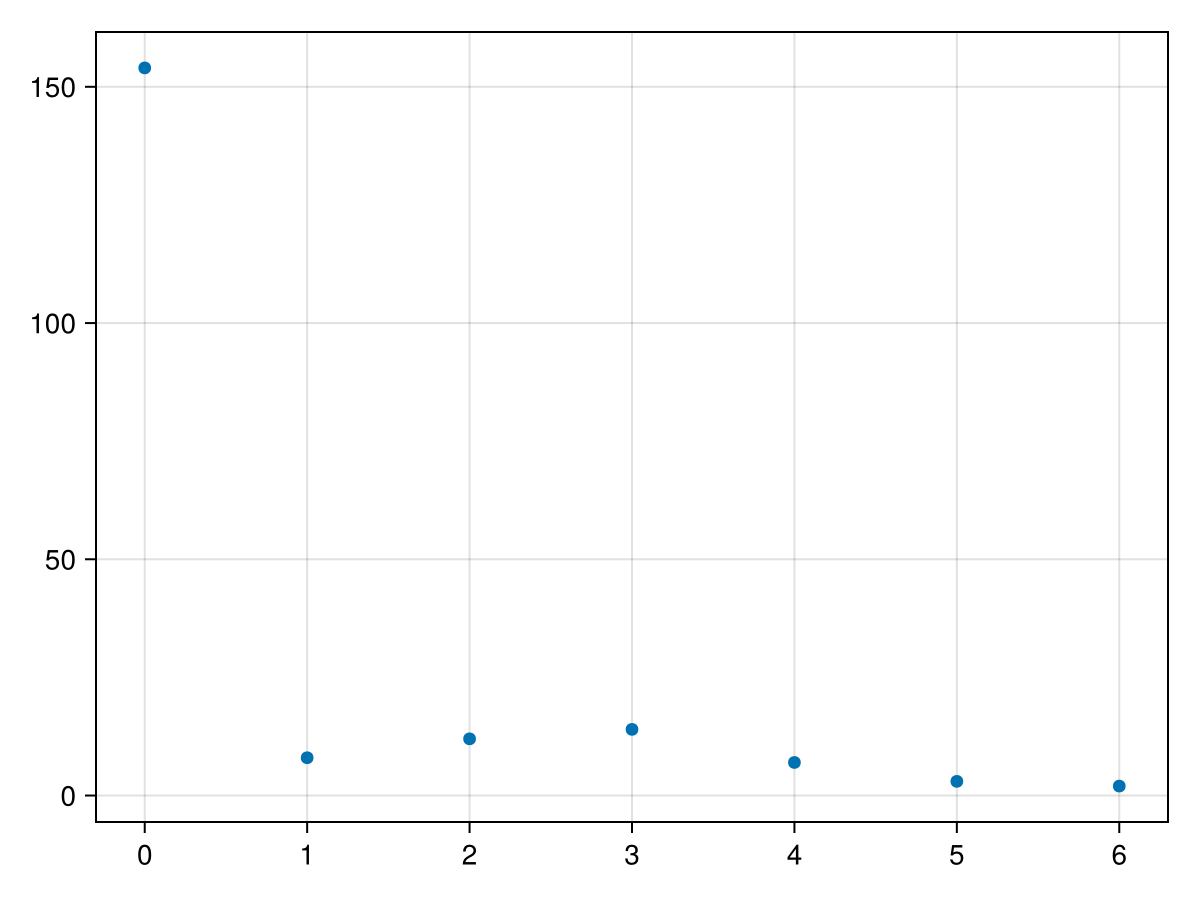

In [357]:
cm = countmap(df.numsurv)
@show cm
nums = sort(collect(keys(cm)))
scatter(nums, [cm[n] for n in nums])

## Selecting runs from that

In [409]:
# Select those with good quality data, that are unstable and have at least 2 surviving species
sdf = @subset(df, 1 .< :numsurv, :good_ss, :good_ls, :lscode .== 2)
nrow(sdf) / nrow(df)

0.12

## Saving for a cluster PDE run

In [437]:
smaller_sdf = sdf[sample(1:nrow(sdf), 1; replace=false),:];

In [435]:
smaller_sdf = @subset(sdf, :numsurv .> 3)
smaller_sdf = smaller_sdf[[6,1,4,2],:]
smaller_sdf.numsurv

4-element Vector{Int64}:
 6
 5
 5
 4

In [436]:
jldsave("./sel_systems1.jld2"; df=smaller_sdf)

In [5]:
@time xx = run_1d_pdes_from_df("./sel_systems1.jld2",
    maxtime=60,
);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:26


268.387332 seconds (724.14 M allocations: 146.542 GiB, 6.01% gc time, 6.01% compilation time: 3% of which was recompilation)


In [445]:
L=5; sN=5000; dx=L/sN;

In [ ]:
3

In [ ]:
function plot_spatial_fs(u, Ns, dx)
    Nr = size(u)[1] - Ns
    xs = ((1:Ns) .- 0.5) .* dx
    
    fig = Figure()
    axs = Axis(fig[1,1])
    axr = Axis(fig[2,1])
    linkxaxes!(axs, axr)

    for i in 1:Ns
        # @show u[i,:]
        # lines!(axs, xs, u[i,:])
    end

    fig
end
plot_spatial_fs(xx.final_states, N, dx)

## Inspecting ss

In [366]:
sr = rand(eachrow(sdf));

In [393]:
xx = @subset(sdf, :numsurv .== 5)
@show nrow(xx)
sr = xx[1,:];

nrow(xx) = 2


In [394]:
N = md(sdf)["N"]
ps = sr.params
ss = sr.steadystates;
cmin = max(minimum(abs, ss), eps())
css = clamp.(ss, cmin, Inf);

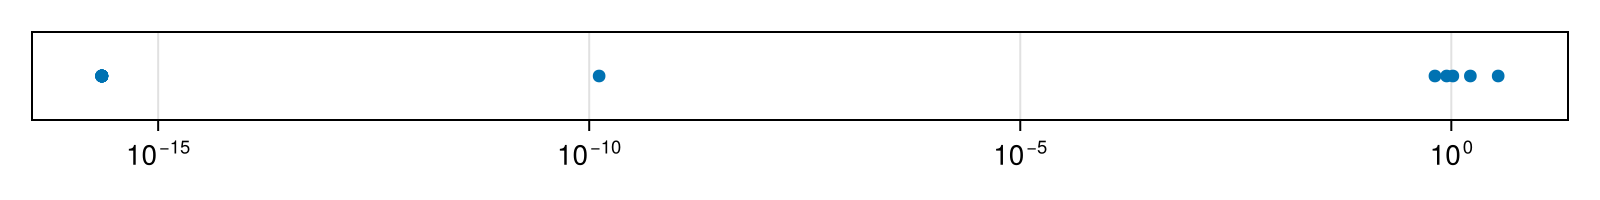

In [395]:
scatter(css[1:N], fill(1, N);
    figure=(; size=(800, 100)),
    axis=(;
        xscale=log10,
        yticks=([], [])
    )
)

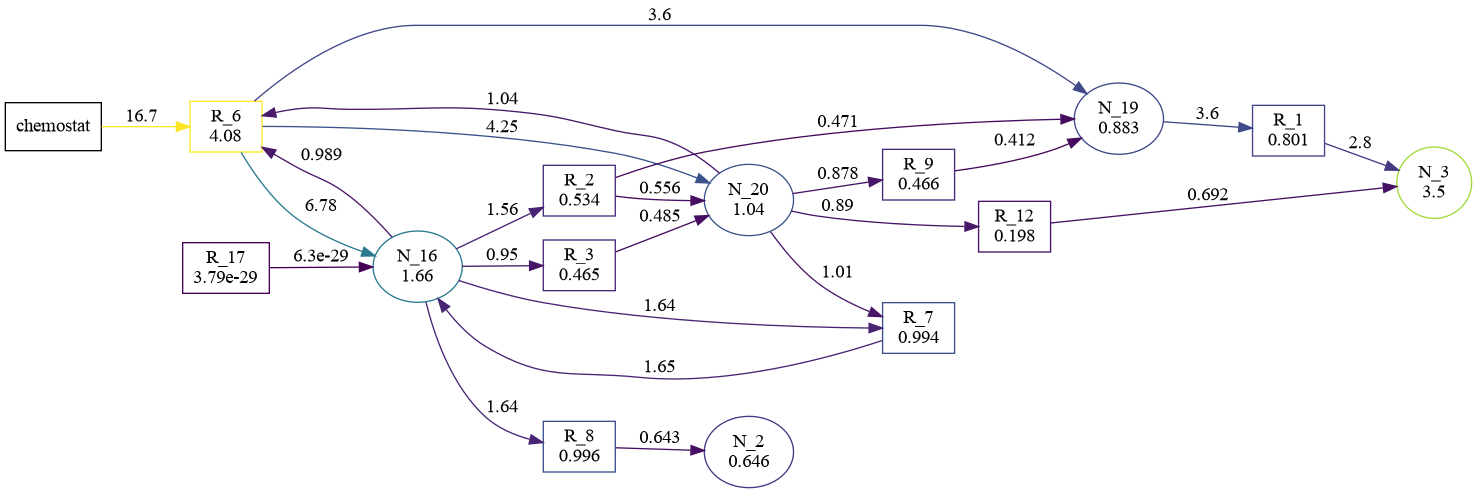

In [398]:
diagram_sfss_v3(ps, ss;
    strain_threshold=1e-2,
    # colorscale=log10,
)

## Plotting full linstab

In [197]:
k_to_evals = linstab_make_k_func(ps, ss)
# ks = 10 .^ range(-5, 3, 100)
ks = range(0.001, 50, 1000)
@time evals = k_to_evals.(ks);

  0.092704 seconds (12.01 k allocations: 35.715 MiB)


[ Info: Unstable, mrl is 0.0142829


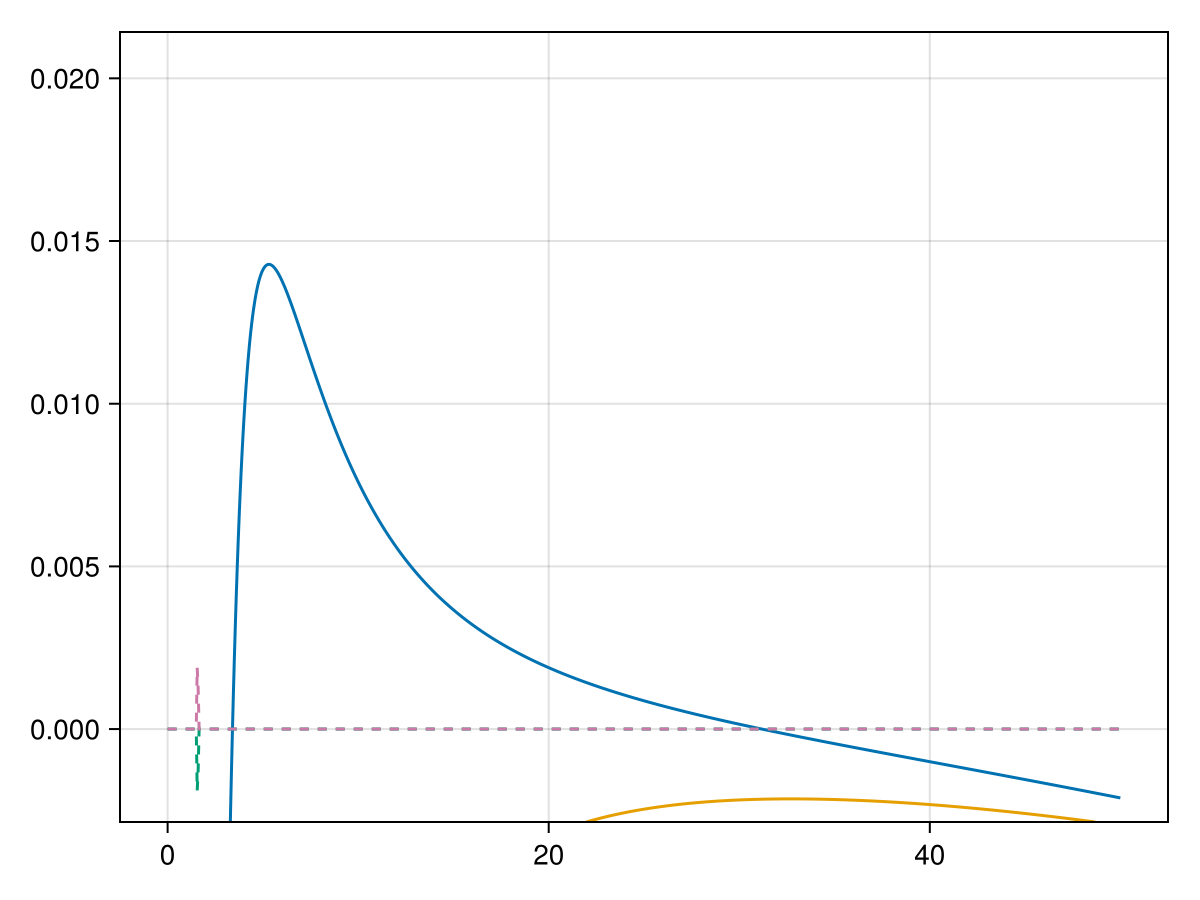

In [198]:
faa = plot_linstab_lambdas(ks, evals;
    axis=(;
        # xscale=log10
    ),
    legend=false
)

# display(GLMakie.Screen(), faa.figure)
faa

# Plotting linstabs